In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from apex import amp
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from warmup_scheduler import GradualWarmupScheduler
from efficientnet_pytorch import model as enet
import albumentations
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from tqdm import tqdm_notebook as tqdm
import warnings
import sys
sys.path.insert(0, './fastai_utils/')
import fastai
from fastai.vision import *
from mish_activation import *
warnings.filterwarnings('ignore')
device = torch.device('cuda')
#device = torch.device('cpu')
fastai.device = device
for i in range(torch.cuda.device_count()):
    print(i, torch.cuda.get_device_name(i))
    print('  allocated:', round(torch.cuda.memory_allocated(i) / 1024 ** 3, 1), 'GB')
    print('  cached:   ', round(torch.cuda.memory_cached(i) / 1024 ** 3, 1), 'GB')

0 Graphics Device
  allocated: 0.0 GB
  cached:    0.0 GB
1 Graphics Device
  allocated: 0.0 GB
  cached:    0.0 GB


In [2]:
MODEL_VER = 'v0'
MAIN_PATH = '.'
DATA_PATH = '{}/data'.format(MAIN_PATH)
TILES_DIR = '{}/train_images_tiles_q1_256_36/'.format(DATA_PATH)
LABELS = '{}/train.csv'.format(DATA_PATH)
MODELS = '{}/effnet_models'.format(MAIN_PATH)
if not os.path.exists('{}_{}'.format(MODELS, MODEL_VER)):
    os.mkdir('{}_{}'.format(MODELS, MODEL_VER))
    print('created:', '{}_{}'.format(MODELS, MODEL_VER))
kernel_type = 'effnet_b1'
enet_type = 'efficientnet-b0'
fold = 0
tile_size = 256
image_size = 256
n_tiles = 25
batch_size = 8
N_WORKERS = 8
out_dim = 5
init_lr = 3e-4
warmup_factor = 10
warmup_epo = 1
DEBUG = False
FMAP = False
APEX = True
n_epochs = 3 if DEBUG else 40
pretrained_model = {
    'efficientnet-b0': './bbs/efficientnet-b0-355c32eb.pth',
    'efficientnet-b1': './bbs/efficientnet-b1-f1951068.pth',
}

In [3]:
if DEBUG:
    df_train = pd.read_csv(os.path.join(DATA_PATH, 'train_dsph.csv')).sample(100).reset_index(drop=True)
else:
    df_train = pd.read_csv(os.path.join(DATA_PATH, 'train_dsph.csv'))
df_train.head()

,Unnamed: 0,image_id,data_provider,isup_grade,gleason_score
0,0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [4]:
skf = StratifiedKFold(5, shuffle=True, random_state=42)
df_train['fold'] = -1
for i, (train_idx, valid_idx) in enumerate(skf.split(df_train, df_train['isup_grade'])):
    df_train.loc[valid_idx, 'fold'] = i
df_train.head()

,Unnamed: 0,image_id,data_provider,isup_grade,gleason_score,fold
0,0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,1
1,1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,3
2,2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,4
3,3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,0
4,4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,2


In [5]:
class EffNet(nn.Module):
    def __init__(self, backbone, out_dim):
        super(EffNet, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        self.enet.load_state_dict(torch.load(pretrained_model[backbone]))
        #self.enet = enet.EfficientNet.from_pretrained(backbone)
        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()
        self.enet = nn.DataParallel(self.enet)
    def extract(self, x):
        return self.enet(x)
    def forward(self, x):
        x = self.extract(x)
        x = self.myfc(x)
        return x
class EffNetFMap(nn.Module):
    def __init__(self, backbone='efficientnet-b0', out_dim=5, pre=True):
        super().__init__()
        m = enet.EfficientNet.from_name(backbone)
        m_layers = nn.ModuleList(m.children())[:-5]
        self.enc = nn.Sequential(*m_layers)
        nc = list(m.children())[-2].in_features
        self.head = nn.Sequential(
            AdaptiveConcatPool2d(),
            Flatten(),
            nn.Linear(nc, int(nc / 2)),
            Mish(),
            nn.BatchNorm1d(int(nc / 2)), 
            nn.Dropout(.4),
            nn.Linear(int(nc / 2), out_dim)
        )
    def forward(self, *x):
        shape = x[0].shape
        n = len(x)
        x = torch.stack(x,1).view(-1,shape[1],shape[2],shape[3])
        #x: bs*N x 3 x 128 x 128
        x = self.enc(x)
        #x: bs*N x C x 4 x 4
        shape = x.shape
        #concatenate the output for tiles into a single map
        x = x.view(-1,n,shape[1],shape[2],shape[3]).permute(0,2,1,3,4).contiguous()\
          .view(-1,shape[1],shape[2]*n,shape[3])
        #x: bs x C x N*4 x 4
        x = self.head(x)
        #x: bs x n
        return x

In [6]:
def get_tiles(img_id):
        result = []
        seq_imgs = []
        for i in range(n_tiles):
            img_path = '{}/{}_{}.png'.format(TILES_DIR, img_id, i)
            img = cv2.imread(img_path)
            if not np.any(img):
                print('no img file read:', img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            seq_imgs.append(img)
        for i in range(len(seq_imgs)):
            result.append({'img':seq_imgs[i], 'idx':i})
        return result
class PANDADataset(Dataset):
    def __init__(self,
                 df,
                 image_size,
                 n_tiles=n_tiles,
                 tile_mode=0,
                 rand=False,
                 transform=None,
                 fmap=False
                ):
        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.n_tiles = n_tiles
        self.tile_mode = tile_mode
        self.rand = rand
        self.transform = transform
        self.fmap = fmap
    def __len__(self):
        return self.df.shape[0]
    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.image_id
        tiles = get_tiles(img_id)
        if self.rand:
            idxes = np.random.choice(list(range(self.n_tiles)), self.n_tiles, replace=False)
        else:
            idxes = list(range(self.n_tiles))
        if not self.fmap:
            n_row_tiles = int(np.sqrt(self.n_tiles))
            images = np.zeros((image_size * n_row_tiles, image_size * n_row_tiles, 3))
            for h in range(n_row_tiles):
                for w in range(n_row_tiles):
                    i = h * n_row_tiles + w
                    if len(tiles) > idxes[i]:
                        this_img = tiles[idxes[i]]['img']
                    else:
                        this_img = np.ones((self.image_size, self.image_size, 3)).astype(np.uint8) * 255
                    this_img = 255 - this_img
                    if self.transform is not None:
                        this_img = self.transform(image=this_img)['image']
                    h1 = h * image_size
                    w1 = w * image_size
                    images[h1:h1+image_size, w1:w1+image_size] = this_img
            if self.transform is not None:
                images = self.transform(image=images)['image']
            images = images.astype(np.float32)
            images /= 255
            images = images.transpose(2, 0, 1)
        else:
            images = []
            for i in idxes:
                this_img = tiles[idxes[i]]['img']
                this_img = 255 - this_img
                if self.transform is not None:
                        this_img = self.transform(image=this_img)['image']
                this_img = this_img.astype(np.float32)
                this_img /= 255
                this_img = this_img.transpose(2, 0, 1)
                images.append(this_img)    
        label = np.zeros(5).astype(np.float32)
        label[:row.isup_grade] = 1.
        return torch.tensor(images), torch.tensor(label)

In [7]:
transforms_train = albumentations.Compose([
    albumentations.Transpose(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
])
transforms_val = albumentations.Compose([])

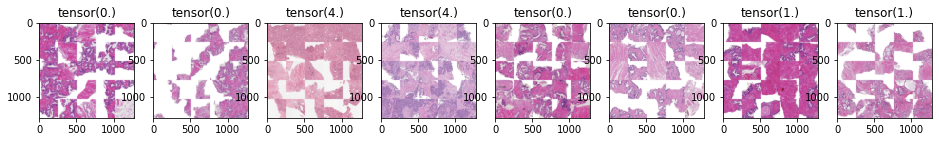

In [8]:
dataset_show = PANDADataset(df_train, image_size, n_tiles, 0, transform=transforms_train, fmap=FMAP)
from pylab import rcParams
rcParams['figure.figsize'] = (16, 4)
if FMAP:
    f, axarr = plt.subplots(1, n_tiles)
    imgs, label = dataset_show.__getitem__(0)
    for t in range(n_tiles):
        axarr[t].imshow(1. - imgs[t].transpose(0, 1).transpose(1,2).squeeze())
        axarr[t].set_title(str(sum(label)))
else:
    f, axarr = plt.subplots(1, batch_size)
    for i in range(batch_size):
        img, label = dataset_show.__getitem__(i)
        axarr[i].imshow(1. - img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[i].set_title(str(sum(label)))

In [9]:
criterion = nn.BCEWithLogitsLoss()
def train_epoch(loader, optimizer):
    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target) in bar:
        data, target = data.to(device), target.to(device)
        loss_func = criterion
        optimizer.zero_grad()
        logits = model(data)
        loss = loss_func(logits, target)
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
        #loss.backward()
        optimizer.step()
        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
    return train_loss
def val_epoch(loader, get_output=False):
    model.eval()
    val_loss = []
    LOGITS = []
    PREDS = []
    TARGETS = []
    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(device), target.to(device)
            logits = model(data)
            loss = criterion(logits, target)
            pred = logits.sigmoid().sum(1).detach().round()
            LOGITS.append(logits)
            PREDS.append(pred)
            TARGETS.append(target.sum(1))
            val_loss.append(loss.detach().cpu().numpy())
        val_loss = np.mean(val_loss)
    LOGITS = torch.cat(LOGITS).cpu().numpy()
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    acc = (PREDS == TARGETS).mean() * 100.
    qwk = cohen_kappa_score(PREDS, TARGETS, weights='quadratic')
    qwk_k = cohen_kappa_score(
        PREDS[df_valid['data_provider'] == 'karolinska'], 
        df_valid[df_valid['data_provider'] == 'karolinska'].isup_grade.values, 
        weights='quadratic'
    )
    qwk_r = cohen_kappa_score(
        PREDS[df_valid['data_provider'] == 'radboud'], 
        df_valid[df_valid['data_provider'] == 'radboud'].isup_grade.values, 
        weights='quadratic'
    )
    print('qwk', qwk, 'qwk_k', qwk_k, 'qwk_r', qwk_r)
    if get_output:
        return LOGITS
    else:
        return val_loss, acc, qwk

In [10]:
train_idx = np.where((df_train['fold'] != fold))[0]
valid_idx = np.where((df_train['fold'] == fold))[0]
df_this  = df_train.loc[train_idx]
df_valid = df_train.loc[valid_idx]
dataset_train = PANDADataset(
    df_this , 
    image_size, 
    n_tiles, 
    transform=transforms_train
)
dataset_valid = PANDADataset(
    df_valid, 
    image_size, 
    n_tiles, 
    transform=transforms_val
)
train_loader = torch.utils.data.DataLoader(
    dataset_train, 
    batch_size=batch_size, 
    sampler=RandomSampler(dataset_train), 
    num_workers=N_WORKERS
)
valid_loader = torch.utils.data.DataLoader(
    dataset_valid, 
    batch_size=batch_size, 
    sampler=SequentialSampler(dataset_valid), 
    num_workers=N_WORKERS
)
if not FMAP:
    model = EffNet(enet_type, out_dim=out_dim)
else:
    model = EffNetFMap(enet_type, out_dim=out_dim)
model = model.to(device)
#optimizer = optim.Adam(model.parameters(), lr=init_lr / warmup_factor)
#scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs - warmup_epo)
optimizer = optim.Adam(model.parameters(), lr=init_lr)
model, optimizer = amp.initialize(model, optimizer, opt_level='O1')
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
#scheduler = optim.lr_scheduler.OneCycleLR(
#    optimizer, 
#    epochs=n_epochs, 
#    steps_per_epoch=len(train_loader),
#    max_lr=init_lr, 
#    pct_start=0.3, 
#    div_factor=100,
#    final_div_factor=1e4
#)
#scheduler = GradualWarmupScheduler(
#    optimizer, 
#    multiplier=warmup_factor, 
#    total_epoch=warmup_epo, 
#    after_scheduler=scheduler_cosine
#)
print(len(dataset_train), len(dataset_valid))

Loaded pretrained weights for efficientnet-b0
Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
8412 2104


In [ ]:
qwk_max = 0.
best_file = '{}_{}/{}_best_fold{}.pth'.format(MODELS, MODEL_VER, kernel_type, fold)
for epoch in range(1, n_epochs + 1):
    print(time.ctime(), 'Epoch:', epoch)
    scheduler.step(epoch - 1)
    train_loss = train_epoch(train_loader, optimizer)
    val_loss, acc, qwk = val_epoch(valid_loader)
    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f}, acc: {(acc):.5f}, qwk: {(qwk):.5f}'
    print(content)
    with open('{}_{}/log_{}.txt'.format(MODELS, MODEL_VER, kernel_type), 'a') as appender:
        appender.write(content + '\n')
    if qwk > qwk_max:
        print('score2 ({:.6f} --> {:.6f}).  Saving model ...'.format(qwk_max, qwk))
        torch.save(model.state_dict(), best_file)
        qwk_max = qwk
torch.save(
    model.state_dict(), 
    os.path.join('{}_{}/{}_final_fold{}.pth'.format(MODELS, MODEL_VER, kernel_type, fold))
)

Tue Jun 30 19:34:42 2020 Epoch: 1


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0




qwk 0.755540829272893 qwk_k 0.7236015011637832 qwk_r 0.7045135044351277
Tue Jun 30 19:48:31 2020 Epoch 1, lr: 0.0003000, train loss: 0.38088, val loss: 0.29953, acc: 48.47909, qwk: 0.75554
score2 (0.000000 --> 0.755541).  Saving model ...
Tue Jun 30 19:48:31 2020 Epoch: 2



qwk 0.8309540033670502 qwk_k 0.8117124901930513 qwk_r 0.7965005167807484
Tue Jun 30 20:02:08 2020 Epoch 2, lr: 0.0002995, train loss: 0.29698, val loss: 0.28528, acc: 54.94297, qwk: 0.83095
score2 (0.755541 --> 0.830954).  Saving model ...
Tue Jun 30 20:02:08 2020 Epoch: 3



qwk 0.8352763805783137 qwk_k 0.8186061544460268 qwk_r 0.805128890488856
Tue Jun 30 20:15:44 2020 Epoch 3, lr: 0.0002982, train loss: 0.26748, val loss: 0.28158, acc: 56.22624, qwk: 0.83528
score2 (0.830954 --> 0.835276).  Saving model ...
Tue Jun 30 20:15:44 2020 Epoch: 4


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0




qwk 0.8464460724482381 qwk_k 0.8460929841410437 qwk_r 0.8032328697157288
Tue Jun 30 20:29:22 2020 Epoch 4, lr: 0.0002959, train loss: 0.25137, val loss: 0.27830, acc: 55.84601, qwk: 0.84645
score2 (0.835276 --> 0.846446).  Saving model ...
Tue Jun 30 20:29:22 2020 Epoch: 5



qwk 0.7581077506484136 qwk_k 0.7450682825760201 qwk_r 0.6967284698025122
Tue Jun 30 20:42:58 2020 Epoch 5, lr: 0.0002927, train loss: 0.23898, val loss: 0.31024, acc: 52.75665, qwk: 0.75811
Tue Jun 30 20:42:58 2020 Epoch: 6


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0




qwk 0.8100276243729394 qwk_k 0.800901104860448 qwk_r 0.7713046338189673
Tue Jun 30 20:56:35 2020 Epoch 6, lr: 0.0002886, train loss: 0.22909, val loss: 0.27652, acc: 59.22053, qwk: 0.81003
Tue Jun 30 20:56:35 2020 Epoch: 7



qwk 0.8571570452727774 qwk_k 0.8510009657113247 qwk_r 0.8266181155215055
Tue Jun 30 21:10:11 2020 Epoch 7, lr: 0.0002837, train loss: 0.21759, val loss: 0.23593, acc: 61.97719, qwk: 0.85716
score2 (0.846446 --> 0.857157).  Saving model ...
Tue Jun 30 21:10:11 2020 Epoch: 8



qwk 0.8466812524929254 qwk_k 0.8290948298205418 qwk_r 0.81501205120233
Tue Jun 30 21:23:48 2020 Epoch 8, lr: 0.0002779, train loss: 0.21479, val loss: 0.23109, acc: 60.93156, qwk: 0.84668
Tue Jun 30 21:23:48 2020 Epoch: 9



qwk 0.8401882486460517 qwk_k 0.8478961276388929 qwk_r 0.7817718555573878
Tue Jun 30 21:37:25 2020 Epoch 9, lr: 0.0002714, train loss: 0.20152, val loss: 0.22483, acc: 58.17490, qwk: 0.84019
Tue Jun 30 21:37:25 2020 Epoch: 10


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0




qwk 0.8204451646068885 qwk_k 0.8248515496224003 qwk_r 0.7593981544615664
Tue Jun 30 21:51:02 2020 Epoch 10, lr: 0.0002641, train loss: 0.19322, val loss: 0.27233, acc: 54.42015, qwk: 0.82045
Tue Jun 30 21:51:02 2020 Epoch: 11



qwk 0.8679870815639111 qwk_k 0.847041723801435 qwk_r 0.8503133583504198
Tue Jun 30 22:04:38 2020 Epoch 11, lr: 0.0002561, train loss: 0.18890, val loss: 0.22763, acc: 62.73764, qwk: 0.86799
score2 (0.857157 --> 0.867987).  Saving model ...
Tue Jun 30 22:04:38 2020 Epoch: 12


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0




qwk 0.8643306366844252 qwk_k 0.862319181192524 qwk_r 0.829468966192601
Tue Jun 30 22:18:15 2020 Epoch 12, lr: 0.0002474, train loss: 0.18139, val loss: 0.22466, acc: 62.64259, qwk: 0.86433
Tue Jun 30 22:18:15 2020 Epoch: 13



qwk 0.7990830219946164 qwk_k 0.798411092757733 qwk_r 0.7582434722929903
Tue Jun 30 22:31:51 2020 Epoch 13, lr: 0.0002382, train loss: 0.17344, val loss: 0.33475, acc: 61.73954, qwk: 0.79908
Tue Jun 30 22:31:51 2020 Epoch: 14



qwk 0.8620583558182449 qwk_k 0.8635531301218033 qwk_r 0.8199454317931605
Tue Jun 30 22:45:27 2020 Epoch 14, lr: 0.0002284, train loss: 0.16710, val loss: 0.21845, acc: 65.25665, qwk: 0.86206
Tue Jun 30 22:45:27 2020 Epoch: 15



qwk 0.861767627527793 qwk_k 0.8647661556573594 qwk_r 0.824153069091939
Tue Jun 30 22:59:04 2020 Epoch 15, lr: 0.0002181, train loss: 0.15950, val loss: 0.25382, acc: 67.25285, qwk: 0.86177
Tue Jun 30 22:59:04 2020 Epoch: 16


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0




qwk 0.8650416441513018 qwk_k 0.8660131756644185 qwk_r 0.8255205666822041
Tue Jun 30 23:12:41 2020 Epoch 16, lr: 0.0002074, train loss: 0.14723, val loss: 0.25020, acc: 65.11407, qwk: 0.86504
Tue Jun 30 23:12:41 2020 Epoch: 17


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0




qwk 0.8705451291398189 qwk_k 0.8667090986024808 qwk_r 0.8394231734420199
Tue Jun 30 23:26:18 2020 Epoch 17, lr: 0.0001964, train loss: 0.14738, val loss: 0.23055, acc: 69.10646, qwk: 0.87055
score2 (0.867987 --> 0.870545).  Saving model ...
Tue Jun 30 23:26:18 2020 Epoch: 18



qwk 0.8654304599216398 qwk_k 0.8497783593516126 qwk_r 0.8419963911795384
Tue Jun 30 23:39:55 2020 Epoch 18, lr: 0.0001850, train loss: 0.13623, val loss: 0.26011, acc: 67.11027, qwk: 0.86543
Tue Jun 30 23:39:55 2020 Epoch: 19
